# Omnigot One-Shot

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import cv2
from scipy.spatial import distance

In [2]:
import vbranch as vb

In [3]:
model_id = 1
architecture = 'simple'

## Load Data

In [4]:
train_generator = vb.datasets.omniglot.load_generator('train')
test_generator = vb.datasets.omniglot.load_generator('test')

In [5]:
batch = test_generator.next(4, 4, 4, flatten=False)

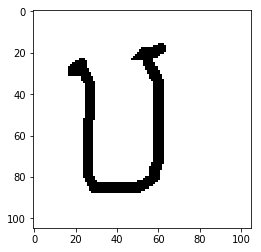

In [6]:
plt.imshow(batch[2, 3, 0].squeeze(), cmap=plt.cm.gray)
plt.show()

## Build Model

In [7]:
EPOCHS = 90
T_0 = 30
STEPS_PER_EPOCH = 100
model_path = './models/omniglot-{}_{}'.format(architecture, model_id)
A, P, K = 4, 8, 4 # triplet batch specs
output_dim = 128
input_dim = [None, 105, 105, 1]

In [8]:
if not os.path.isdir('./models'):
    os.system('mkdir models')

In [9]:
def batch_gen(A, P, K):
    def func():
        while True:
            batch = train_generator.next(A, P, K)
            batch = batch.astype('float32')
            yield batch
    return func

In [10]:
tf.reset_default_graph()

train_dataset = tf.data.Dataset.from_generator(batch_gen(A, P, K), 'float32', 
                                                 output_shapes=input_dim)

# Dataset for feeding non-triplet batched images from memory
x = tf.placeholder('float32', input_dim, name='x')
batch_size = tf.placeholder('int64', name='batch_size')
test_dataset = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)

iter_ = tf.data.Iterator.from_structure('float32', input_dim)
train_init_op = iter_.make_initializer(train_dataset)
test_init_op = iter_.make_initializer(test_dataset, name='test_init_op')

inputs = iter_.get_next()

In [11]:
if architecture == 'simple':
    model = vb.simple_cnn(inputs, output_dim, 32, 64, 128, 256, 
                          name='model_' + str(model_id))
elif architecture == 'res':
    model = vb.resnet(inputs, output_dim, 32, 64, 128, 256, 
                      name='model_' + str(model_id))

In [12]:
model.summary()

i   Layer name         Output shape       Parameters            Num param  Inbound            
----------------------------------------------------------------------------------------------
    Input              [None,105,105,1]                                                       
----------------------------------------------------------------------------------------------
0   conv2d_1_1         [None,103,103,32]  [3,3,1,32] [32]       320        IteratorGetNext:0  
----------------------------------------------------------------------------------------------
1   bn_1_1             [None,103,103,32]  [32] [32]             64         conv2d_1_1         
----------------------------------------------------------------------------------------------
2   relu_1_1           [None,103,103,32]                        0          bn_1_1             
----------------------------------------------------------------------------------------------
3   conv2d_1_2         [None,101,101,32]  [3,3,32,

In [13]:
def lr_exp_decay_scheduler(init_lr, t0, t1, decay):
    """NOTE: `episode` starts from 1"""
    def func(episode):
        if episode < t0:
            return init_lr
        lr = init_lr * np.power(decay, (episode - t0) / (t1 - t0))
        return lr
    return func

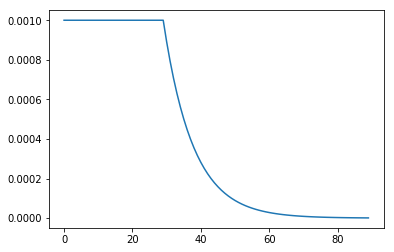

In [14]:
lr_scheduler = lr_exp_decay_scheduler(0.001, T_0, EPOCHS, 0.001)
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [15]:
lr = tf.placeholder('float32', name='lr')
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

model.compile(optimizer, 'triplet_omniglot', A=A, P=P, K=K)

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(train_init_op)

    for e in range(EPOCHS):
        print("Epoch {}/{}".format(e + 1, EPOCHS))
        progbar = tf.keras.utils.Progbar(STEPS_PER_EPOCH)
        
        learning_rate = lr_scheduler(e + 1)
        for i in range(STEPS_PER_EPOCH):
            _, loss_value = sess.run([model.train_op, model.loss], feed_dict={lr:learning_rate})
            progbar.update(i + 1, values=[('loss', loss_value), ('lr', learning_rate)])
    
    saver = tf.train.Saver()
    path = os.path.join(model_path, 'ckpt')
    saver.save(sess, path)

Epoch 1/90
100/100 [==============================] - 39s 393ms/step - loss: 248.0973 - lr: 0.0010
Epoch 2/90
100/100 [==============================] - 25s 247ms/step - loss: 61.7863 - lr: 0.0010
Epoch 3/90
100/100 [==============================] - 23s 232ms/step - loss: 40.0774 - lr: 0.0010
Epoch 4/90
100/100 [==============================] - 21s 215ms/step - loss: 32.6180 - lr: 0.0010
Epoch 5/90
100/100 [==============================] - 21s 209ms/step - loss: 31.6464 - lr: 0.0010
Epoch 6/90
100/100 [==============================] - 20s 204ms/step - loss: 27.9680 - lr: 0.0010
Epoch 7/90
100/100 [==============================] - 20s 201ms/step - loss: 24.4837 - lr: 0.0010
Epoch 8/90
100/100 [==============================] - 20s 200ms/step - loss: 24.0631 - lr: 0.0010
Epoch 9/90
100/100 [==============================] - 20s 198ms/step - loss: 26.6990 - lr: 0.0010
Epoch 10/90
100/100 [==============================] - 20s 198ms/step - loss: 22.3999 - lr: 0.0010
Epoch 11/90
100/10

## Model Ensemble

In [8]:
def restore_sess(sess, model_path):
    meta_path = os.path.join(model_path, 'ckpt.meta')
    ckpt = tf.train.get_checkpoint_state(model_path)

    imported_graph = tf.train.import_meta_graph(meta_path)
    imported_graph.restore(sess, ckpt.model_checkpoint_path)

In [9]:
def get_run(n_run):
    all_runs = 'omniglot/python/one-shot-classification/all_runs'
    
    if not os.path.isdir(all_runs):
        with zipfile.ZipFile(all_runs + '.zip','r') as zip_ref:
            zip_ref.extractall(all_runs)
    
    run_path = os.path.join(all_runs,'run%02d'%n_run,'class_labels.txt')
    with open(run_path) as f:
        content = f.read().splitlines()

    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]

    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()
    
    def f_load(f):
        path = os.path.join(all_runs, f)
        return cv2.imread(path)[..., 0]

    train_imgs = np.stack([f_load(f) for f in train_files]).\
                        astype('float32')[..., np.newaxis]
    test_imgs  = np.stack([f_load(f) for f in test_files]).\
                        astype('float32')[..., np.newaxis]

    return train_files, test_files, train_imgs, test_imgs, answers_files

In [10]:
def compute_one_shot_acc(test_pred, train_pred, train_files, answers_files):
    n_test = len(test_pred)
    n_train = len(train_pred)
    
    distM = np.zeros((n_test, n_train))
    for i in range(n_test):
        for c in range(n_train):
            distM[i,c] = distance.euclidean(test_pred[i],train_pred[c])
            
    YHAT = np.argmin(distM, axis=1)
    
    # compute the error rate
    correct = 0.0
    for i in range(n_test):
        if train_files[YHAT[i]] == answers_files[i]:
            correct += 1.0
        
    return correct / n_test

In [12]:
total_runs = 20
run_data = [get_run(r+1) for r in range(total_runs)]

model_train_runs = []
model_test_runs = []

for i in [0]:
    train_runs = []
    test_runs = []

    graph = tf.Graph()
    sess = tf.Session(graph=graph)

    with sess.as_default(), graph.as_default():
        restore_sess(sess, model_path)

        for r in range(total_runs):
            train_files,test_files,train_ims,test_ims,answers_files = \
                run_data[r]

            feed_dict = {'x:0':train_ims,'batch_size:0':len(train_ims)}
            sess.run('test_init_op', feed_dict=feed_dict)
            train_runs.append(sess.run('model_%d'%(i+1)+'/'+'output:0'))

            feed_dict = {'x:0':test_ims, 'batch_size:0':len(test_ims)}
            sess.run('test_init_op', feed_dict=feed_dict)
            test_runs.append(sess.run('model_%d'%(i+1)+'/'+'output:0'))

    model_train_runs.append(train_runs)
    model_test_runs.append(test_runs)

INFO:tensorflow:Restoring parameters from ./models/omniglot-simple_1/ckpt


### Average Embedding

In [13]:
mean_acc_runs = []

test_embed = np.mean(model_test_runs, axis=0)
train_embed = np.mean(model_train_runs, axis=0)

for r in range(total_runs):
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]

    acc = compute_one_shot_acc(test_embed[r], train_embed[r],train_files,answers_files)
    mean_acc_runs.append(acc)

In [14]:
print(mean_acc_runs)
print(np.mean(mean_acc_runs))

[0.6, 0.4, 0.5, 0.7, 0.75, 0.65, 0.3, 0.65, 0.35, 0.5, 0.85, 0.6, 0.35, 0.55, 0.95, 0.85, 0.7, 0.5, 0.4, 0.6]
0.5875


### Concatenate Embedding

In [15]:
concat_acc_runs = []

test_embed = np.concatenate(model_test_runs, axis=-1)
train_embed = np.concatenate(model_train_runs, axis=-1)

for r in range(total_runs):
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]
    
    acc = compute_one_shot_acc(test_embed[r], train_embed[r],train_files, answers_files)
    concat_acc_runs.append(acc)

In [16]:
test_embed.shape

(20, 20, 128)

In [17]:
print(concat_acc_runs)
print(np.mean(concat_acc_runs))

[0.6, 0.4, 0.5, 0.7, 0.75, 0.65, 0.3, 0.65, 0.35, 0.5, 0.85, 0.6, 0.35, 0.55, 0.95, 0.85, 0.7, 0.5, 0.4, 0.6]
0.5875
